In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/bit_conference/

/content/gdrive/.shortcut-targets-by-id/1YDrmXvwQeDTF3AVegVo_-qlULY2-1-qE/bit_conference


## 데이터

노래 데이터

In [3]:
import pandas as pd

df_lyrics_classified = pd.read_csv("coding/df_lyrics_classified.csv")

사용자 플레이리스트 지정

In [4]:
id = [1776, 1785, 1877, 1911, 1975]
df_user_playlist = df_lyrics_classified.iloc[id]
df_user_playlist

,artist_name,track_name,long_lyrics,lyrics_summary,genre,release_date,views,danceability,loudness,acousticness,...,prob_Exciting,prob_Heartwarming,prob_Hopeful,prob_Lonely,prob_Romantic,prob_Sad,prob_Stress,predicted_label_1,predicted_label_2,predicted_label_3
1776,maroon 5,maps,miss the taste of sweeter life miss the conver...,The speaker is reminiscing about a past relati...,pop,2015,521416,0.736814,0.772633,0.020581,...,0.000346,0.000749,0.000412,0.044629,0.001454,0.950162,0.001787,Sad,Lonely,Stress
1785,justin bieber,purpose,feeling like am breathing my last breath feeli...,The speaker is reflecting on the end of their ...,pop,2015,480854,0.457381,0.635695,0.902610,...,0.000821,0.978248,0.005311,0.001862,0.007246,0.002608,0.001178,Heartwarming,Romantic,Hopeful
1877,the weeknd,starboy,am tryna put you in the worst mood ah p1 clean...,"The speaker is taunting someone, calling them ...",pop,2016,6784046,0.667497,0.734354,0.141565,...,0.004354,0.153255,0.001675,0.726631,0.007813,0.086924,0.016342,Lonely,Heartwarming,Sad
1911,bruno mars,chunky,she got to shake her little something throwin ...,"The lyrics describe a night out with friends, ...",pop,2016,328805,0.551608,0.800220,0.020883,...,0.004291,0.987949,0.000712,0.001734,0.001931,0.000731,0.001128,Heartwarming,Exciting,Romantic
1975,billie eilish,idontwannabeyouanymore,do not be that way fall apart twice day just w...,The song appears to be about a toxic relations...,pop,2017,2803781,0.456298,0.697280,0.739960,...,0.001190,0.004958,0.001882,0.041204,0.003897,0.793437,0.151983,Sad,Stress,Lonely


사용자 사진

In [5]:
from PIL import Image

image_path = '시연/KakaoTalk_20250221_152301385.jpg'
Image.open(image_path).convert("RGB")

Output hidden; open in https://colab.research.google.com to view.

## 사진 감정 분류

사진 감정 추출

In [6]:
import torch
import pandas as pd
from transformers import AutoModelForImageClassification, AutoImageProcessor
from PIL import Image

# 감정 클래스 정의
EMOTIONS = ["Exciting", "Hopeful", "Romantic",
            "Heartwarming", "Calm", "Sad", "Stress", "Lonely"]

# 모델 예측 및 데이터프레임 변환 함수
def predict(image_path):
    # 모델 및 프로세서 로드
    model = AutoModelForImageClassification.from_pretrained("/content/gdrive/MyDrive/bit_conference/efficientnet_emotion_model")
    processor = AutoImageProcessor.from_pretrained("/content/gdrive/MyDrive/bit_conference/efficientnet_emotion_model")
    model.eval()

    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert("RGB")
    inputs = processor(image, return_tensors="pt")

    # 예측 수행
    with torch.no_grad():
        logits = model(**inputs).logits

    # 소프트맥스 확률 계산
    probs = torch.nn.functional.softmax(logits, dim=-1).squeeze()

    # 가장 높은 확률과 두 번째로 높은 확률의 인덱스 찾기
    top2_indices = probs.argsort(descending=True)[:2].tolist()

    # 데이터프레임 생성 (1행짜리)
    df = pd.DataFrame([{
        "Top1": EMOTIONS[top2_indices[0]],  # 가장 높은 확률의 감정
        "Top2": EMOTIONS[top2_indices[1]],  # 두 번째로 높은 확률의 감정
        **{emotion: probs[i].item() for i, emotion in enumerate(EMOTIONS)}  # 감정별 확률값
    }])

    return df

# 예측 실행
df_result = predict(image_path)
df_result

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


,Top1,Top2,Exciting,Hopeful,Romantic,Heartwarming,Calm,Sad,Stress,Lonely
0,Romantic,Lonely,0.115413,0.101679,0.182112,0.109646,0.118512,0.133995,0.101725,0.136919


관련 감정 곡만 필터링

In [7]:
import pandas as pd

# df_lyrics_classified 필터링 함수
def filter_lyrics_by_prediction(df_lyrics_classified, df_result):
    top1_label = df_result["Top1"].values[0]  # Top1 라벨 값
    top2_label = df_result["Top2"].values[0]  # Top2 라벨 값

    # 필터링 조건:
    mask = (
        df_lyrics_classified["predicted_label_1"].eq(top1_label) |
        df_lyrics_classified["predicted_label_2"].eq(top1_label) |
        df_lyrics_classified["predicted_label_3"].eq(top1_label) |
        df_lyrics_classified["predicted_label_1"].eq(top2_label) |
        df_lyrics_classified["predicted_label_2"].eq(top2_label)
    )

    # 필터링된 데이터프레임 반환
    df_filtered = df_lyrics_classified[mask].reset_index(drop=True)

    return df_filtered

# 예제 실행
df_filtered_result = filter_lyrics_by_prediction(df_lyrics_classified, df_result)
df_filtered_result


,artist_name,track_name,long_lyrics,lyrics_summary,genre,release_date,views,danceability,loudness,acousticness,...,prob_Exciting,prob_Heartwarming,prob_Hopeful,prob_Lonely,prob_Romantic,prob_Sad,prob_Stress,predicted_label_1,predicted_label_2,predicted_label_3
0,andy williams,it's the most wonderful time of the year,its the most wonderful time of the year with t...,The holiday season is a time of joy and celebr...,pop,1953,27015,0.194195,0.655642,0.778112,...,0.009044,0.969682,0.000786,0.001636,0.014678,0.001271,0.000885,Heartwarming,Romantic,Exciting
1,bobby vinton,blue velvet,she wore blue velvet bluer than velvet was the...,The song appears to be a romantic and poetic t...,pop,1954,26447,0.428138,0.642694,0.873494,...,0.000662,0.009439,0.000760,0.056849,0.009273,0.921308,0.000747,Sad,Lonely,Heartwarming
2,andy williams,(where do i begin) love story,where do begin to tell the story of how great ...,The song's narrator is drawn to a person who b...,pop,1957,54831,0.284090,0.636156,0.632530,...,0.005218,0.047077,0.002462,0.110882,0.490184,0.335902,0.005636,Romantic,Sad,Lonely
3,simon & garfunkel,mrs. robinson,dee dee dee dee dee dee dee dee dee dee dee de...,"Unfortunately, I don't see any meaningful lyri...",pop,1959,311410,0.586267,0.531882,0.783132,...,0.001769,0.000841,0.000621,0.270369,0.001449,0.712773,0.010975,Sad,Lonely,Stress
4,neil sedaka,oh! carol,carol am but fool darling love you though you ...,The speaker is deeply in love with someone who...,pop,1959,36542,0.721651,0.831295,0.632530,...,0.001687,0.061295,0.003181,0.586920,0.037778,0.296656,0.010885,Lonely,Sad,Heartwarming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,denzel curry,gook,ronny listen up am gook if told you that was n...,"The rapper reflects on his past as a ""gook"" (a...",hip hop,2019,300881,0.656666,0.786939,0.161646,...,0.004952,0.028906,0.006014,0.585286,0.001038,0.184017,0.174487,Lonely,Sad,Stress
2991,kurtis blow,basketball,they are playing basketball we love that baske...,"The speaker is enthusiastic about basketball, ...",hip hop,2019,103924,0.883028,0.702766,0.077509,...,0.012833,0.975892,0.001264,0.001370,0.005565,0.000885,0.001046,Heartwarming,Exciting,Romantic
2992,q-tip,life is better,lifes filled with gray but now it comes clean ...,The song expresses a carefree and nostalgic at...,hip hop,2019,24323,0.885194,0.729098,0.364457,...,0.004789,0.027256,0.004510,0.081077,0.004106,0.862020,0.006281,Sad,Lonely,Heartwarming
2993,rakim,when i b on tha mic,hardcore real ill am internationally known whe...,The rapper confidently asserts their internati...,hip hop,2019,118179,0.838622,0.726226,0.045581,...,0.003824,0.968674,0.002798,0.007730,0.002362,0.003011,0.005901,Heartwarming,Lonely,Stress


## 사진 요약문 생성

In [8]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

# 파인튜닝된 모델과 프로세서 불러오기
processor = BlipProcessor.from_pretrained("image_captioning")
model = BlipForConditionalGeneration.from_pretrained("image_captioning")

# GPU 사용 가능하면 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [9]:
# 테스트할 이미지 로드 (경로 변경 가능)
# image_path =
image = Image.open(image_path).convert("RGB")

# 모델 입력 변환
inputs = processor(image, return_tensors="pt").to(device)

# 캡션 생성 (Beam Search 적용)
outputs = model.generate(**inputs, max_length=200, num_beams=1)
caption = processor.decode(outputs[0], skip_special_tokens=True)

# 결과 출력
print("🔹 Generated Caption:", caption)

🔹 Generated Caption: in this image, we can see a person wearing a coat and standing on the floor. in the background, there are lights and we can see snow.


In [10]:
caption = 'at the top of the image there is dark sky. in the middle of the image a person is standing on the floor.'

## 요약문 매핑 (LLAMA&BLIP)

In [11]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util

# --- Step 1: 모델 불러오기 ---
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- Step 2: 가사 요약 임베딩 생성 ---

def precompute_lyrics_embeddings(df, lyrics_column='lyrics_summary'):
    lyrics_list = df[lyrics_column].tolist()
    embeddings = model.encode(lyrics_list, convert_to_tensor=True)
    return embeddings

# 데이터의 곡 이름과 가사 요약만 불러오기
data = {
    'track_name': df_filtered_result['track_name'].tolist(),
    'lyrics': df_filtered_result['lyrics_summary'].tolist()
}
df_filtered_result_ = pd.DataFrame(data)
df_filtered_result_ = df_filtered_result_.rename(columns={'lyrics': 'lyrics_summary'})

# 요약된 가사에 대해서 임베딩 미리 만들어두기
lyrics_embeddings = precompute_lyrics_embeddings(df_filtered_result_, lyrics_column='lyrics_summary')

# 임베딩 저장
torch.save(lyrics_embeddings, "lyrics_embeddings.pt") # --> 한 번 생성해두면 이 셀은 이제 안돌려도 됨. 그냥 torch.load('lyrics_embedding.pt')로 이후엔 임베딩 불러오면 됩. 이 셀은 초기 임베딩 학습 용

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util
# --- Step 3: Runtime Function to Compute Recommendations ---

model = SentenceTransformer('all-MiniLM-L6-v2')


def compute_cosine_similarity_with_precomputed(image_description: str, df: pd.DataFrame, lyrics_embeddings) -> pd.DataFrame:
    # 이미지 요약문 인코딩
    image_embedding = model.encode(image_description, convert_to_tensor=True)

    # 이미지와 가사 임베딩의 코사인 유사도 계산
    cosine_scores = util.pytorch_cos_sim(image_embedding, lyrics_embeddings)

    df = df.copy()

    df['score'] = cosine_scores[0].tolist()
    #df = df.sort_values(by='score', ascending=False)
    return df

# --- Step 4: Use the Runtime Function ---

# 이미지 요약문 저장
image_description = caption

# 로걸 경로에 저장했으면 바로 아래 코드로 실행
#lyrics_embeddings = torch.load("/content/drive/MyDrive/bit_conference/lyrics_embeddings.pt")
lyrics_embeddings = torch.load("lyrics_embeddings.pt")

# 사전에 만들어둔 가사 임베딩을 입력된 이미지 요약문과 코사인 유사도 계산
recommendations_df = compute_cosine_similarity_with_precomputed(image_description, df_filtered_result_, lyrics_embeddings)

# 노래 이름과 유사도 점수 출력
print("Song recommendations based on cosine similarity:")
print(recommendations_df[['track_name', 'score']])

Song recommendations based on cosine similarity:
                                    track_name     score
0     it's the most wonderful time of the year  0.039649
1                                  blue velvet  0.085270
2                (where do i begin) love story  0.199077
3                                mrs. robinson  0.076693
4                                    oh! carol  0.061497
...                                        ...       ...
2990                                      gook  0.049987
2991                                basketball  0.065922
2992                            life is better  0.153579
2993                       when i b on tha mic  0.090896
2994                                    r.i.p.  0.109118

[2995 rows x 2 columns]


<ipython-input-12-37c4cc1f1439>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lyrics_embeddings = torch.load("lyrics_embeddings.pt")


## 메타데이터 매핑

df_filtered_result = 감정 필터링된 곡들

In [13]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

song_data = df_filtered_result[['release_date', 'views', 'artist_name', 'track_name', 'danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy']]

# 로그 변환 후 0에서 1로 정규화: views
song_data['views'] = np.log1p(song_data['views'])  # 로그 변환 (log(views + 1))

scaler_views = MinMaxScaler()
song_data['views'] = scaler_views.fit_transform(song_data[['views']])

# release_date를 datetime 형식으로 변환 후 정규화
song_data['release_date'] = pd.to_datetime(song_data['release_date'])
song_data['release_date'] = song_data['release_date'].astype(int) // 10**9  # 타임스탬프 변환

scaler_date = MinMaxScaler()
song_data['release_date'] = scaler_date.fit_transform(song_data[['release_date']])



<ipython-input-13-58a86bde667b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_data['views'] = np.log1p(song_data['views'])  # 로그 변환 (log(views + 1))
<ipython-input-13-58a86bde667b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_data['views'] = scaler_views.fit_transform(song_data[['views']])
<ipython-input-13-58a86bde667b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [14]:
# 숫자 특성만 선택
from sklearn.preprocessing import MinMaxScaler
import numpy as np

playlist_data_only = df_user_playlist.select_dtypes(include=['number'])

# 로그 변환 및 정규화 적용
scaler = MinMaxScaler()

# 각 열에 대해 로그 변환 및 정규화 수행
for column in playlist_data_only.columns:
    # 양수인 경우에만 로그 변환
    if (playlist_data_only[column] > 0).all():
        playlist_data_only[column] = np.log1p(playlist_data_only[column])

    # 정규화
    playlist_data_only[column] = scaler.fit_transform(playlist_data_only[[column]])

In [15]:
# 숫자 특성 열별로 평균 낸 후 원본 형태로 돌려놓기
playlist_data_averaged = playlist_data_only.mean().to_frame().T
playlist_data_averaged

,release_date,views,danceability,loudness,acousticness,instrumentalness,valence,energy,prob_Calm,prob_Exciting,prob_Heartwarming,prob_Hopeful,prob_Lonely,prob_Romantic,prob_Sad,prob_Stress
0,0.40005,0.397197,0.426578,0.567116,0.407372,0.2,0.466188,0.538351,0.539226,0.462835,0.441129,0.324109,0.229646,0.474226,0.400214,0.222501


In [16]:
# 노래 속성 데이터 열 정의
song_data_col = ['release_date', 'views','danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy']

# 평균된 속성 데이터의 데이터만 뽑아오기
playlist_data_only = playlist_data_averaged.iloc[0]

# 제곱오차 계산하기
df_filtered_result['squared_diff'] = (df_filtered_result[song_data_col].subtract(playlist_data_only, axis=1) ** 2).sum(axis=1)

# 제곱오차를 정규화한 후 1에서 빼줌(제곱오차가 낮을 수록 좋은 것이기 때문에)
df_filtered_result['sd_reverse_norm'] = 1 - (df_filtered_result['squared_diff'] - df_filtered_result['squared_diff'].min()) / (df_filtered_result['squared_diff'].max() - df_filtered_result['squared_diff'].min())

In [17]:
# 캡션과 가사의 유사도로 측정된 점수를 df_filtered_result에 합쳐주기
df_filtered_result_combined = pd.concat([df_filtered_result, recommendations_df['score']], axis=1)

df_filtered_result_combined['score_norm'] = (df_filtered_result_combined['score'] - df_filtered_result_combined['score'].min()) / (df_filtered_result_combined['score'].max() - df_filtered_result_combined['score'].min())

# 최종 추천 점수는 sd_reverse_norm(정규화된 노래 속성 유사도 점수) + score_norm(정규화된 캡션-가사 유사도) 값으로 함
df_filtered_result_combined['rec_score'] = df_filtered_result_combined['sd_reverse_norm'] + df_filtered_result_combined['score_norm']
df_filtered_result_combined.sort_values(by='rec_score', ascending=False).iloc[0:5,[0,1,2,-4,-2,-1]]

,artist_name,track_name,long_lyrics,sd_reverse_norm,score_norm,rec_score
539,avril lavigne,i'm with you,am standin on the bridge am waitin in the dark...,0.999821,1.000000,1.999821
1966,led zeppelin,the battle of evermore,the queen of light took her and then she turne...,0.999853,0.959799,1.959652
522,coldplay,daylight,to my surprise and my delight saw sunrise saw ...,1.000000,0.924682,1.924682
659,thirty seconds to mars,from yesterday,hes stranger to some and vision to none he can...,0.999993,0.917467,1.917460
1588,kenny chesney,when the sun goes down,sun tanned toes tickling the sand cold drink c...,1.000000,0.905606,1.905606


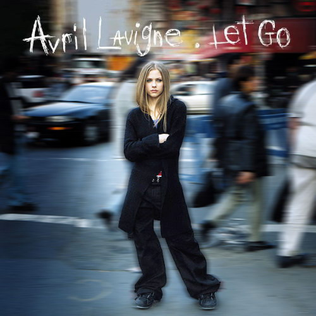

In [21]:
Image.open('avril_lavigne.png').convert("RGB")

In [22]:
print('''I'm standing on a bridge
I'm waitin' in the dark
I thought that you'd be here by now
There's nothing but the rain
No footsteps on the ground
I'm listening but there's no sound
Isn't anyone tryin' to find me?
Won't somebody come take me home?
It's a damn cold night
Trying to figure out this life
Won't you take me by the hand?
Take me somewhere new
I don't know who you are
But I, I'm with you
I'm with you
I'm looking for a place
I'm searching for a face
Is anybody here I know
'Cause nothing's going right
And everything's a mess
And no one likes to be alone
Isn't anyone tryin' to find me?
Won't somebody come take me home?
It's a damn cold night
Trying to figure out this life
Won't you take me by the hand?
Take me somewhere new
I don't know who you are
But I, I'm with you
I'm with you, yeah, yeah
Oh, why is everything so confusing?
Maybe I'm just out of my mind
Yeah, yeah, yeah, yeah, yeah
Yeah, yeah, yeah, yeah
Yeah
It's a damn cold night
Trying to figure out this life
Won't you take me by the hand?
Take me somewhere new
I don't know who you are
But I, I'm with you
I'm with you
Take me by the hand
Take me somewhere new
I don't know who you are
But I, I'm with you
I'm with you
Take me by the hand
Take me somewhere new
I don't know who you are
But I, I'm with you
I'm with you
I'm with you''')

I'm standing on a bridge
I'm waitin' in the dark
I thought that you'd be here by now
There's nothing but the rain
No footsteps on the ground
I'm listening but there's no sound
Isn't anyone tryin' to find me?
Won't somebody come take me home?
It's a damn cold night
Trying to figure out this life
Won't you take me by the hand?
Take me somewhere new
I don't know who you are
But I, I'm with you
I'm with you
I'm looking for a place
I'm searching for a face
Is anybody here I know
'Cause nothing's going right
And everything's a mess
And no one likes to be alone
Isn't anyone tryin' to find me?
Won't somebody come take me home?
It's a damn cold night
Trying to figure out this life
Won't you take me by the hand?
Take me somewhere new
I don't know who you are
But I, I'm with you
I'm with you, yeah, yeah
Oh, why is everything so confusing?
Maybe I'm just out of my mind
Yeah, yeah, yeah, yeah, yeah
Yeah, yeah, yeah, yeah
Yeah
It's a damn cold night
Trying to figure out this life
Won't you take me b